In [1]:
import os

from pandas.conftest import datapath

os.listdir()

['243_22562_220-pycharm-support-libs',
 'Phase1.npz',
 '._.DS_Store',
 'data',
 '243_23654_177-pycharm-support-libs',
 'phase3_new.npz',
 'Phase2.npz',
 'pds',
 '.DS_Store',
 'Phase3_prev.npz',
 'Phase3.npz']

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [26]:
from pds.DSS_analyzer_Mariner import Data1D_GAUGE, Data1D_PumpingCurve
from pds.core import pds, mesh_utils

In [6]:
datapath = "./data"
# Gauge data
gauge_data_folder = datapath + "/gauge_data_swell"

In [8]:
# Load the pressure gauge data. Most close to the first stage is gauge 6. For the stage 8 I need to use gauge 7.
gauge_dataframe = Data1D_GAUGE.Data1D_GAUGE(gauge_data_folder + f"/gauge6_data_swell.npz")
gauge_dataframe_next = Data1D_GAUGE.Data1D_GAUGE(gauge_data_folder + f"/gauge7_data_swell.npz")

# Load the pumping curve data (stage7; stage8)
pumping_curve_filepath = datapath + f"/pumping_curve/pumping_curve_stage7.npz"
pumping_curve_dataframe = Data1D_PumpingCurve.Data1D_PumpingCurve(pumping_curve_filepath)

In [17]:
stage7_start_time = pumping_curve_dataframe.get_start_time()
stage7_end_time = pumping_curve_dataframe.get_end_time()
pumping_curve_filepath_next = datapath + f"/pumping_curve/pumping_curve_stage8.npz"
pumping_curve_dataframe_next = Data1D_PumpingCurve.Data1D_PumpingCurve(pumping_curve_filepath_next)
stage8_start_time = pumping_curve_dataframe_next.get_start_time()
stage8_end_time = pumping_curve_dataframe_next.get_end_time()
# Crop the pressure gauge data
gauge_dataframe.crop(stage7_start_time, stage8_end_time)

In [27]:
# Load the frac hit data
frac_hit_datapath = datapath + "/geometry/frac_hit/"
from pds.DSS_analyzer_Mariner import Data3D_geometry
frac_hit_dataframe_stage7 = Data3D_geometry.Data3D_geometry(frac_hit_datapath + "frac_hit_stage_7_swell.npz")
frac_hit_dataframe_stage8 = Data3D_geometry.Data3D_geometry(frac_hit_datapath + "frac_hit_stage_8_swell.npz")

In [28]:
# Load the gauge md data
gauge_md_datapath = datapath + "/geometry/gauge_md_swell.npz"
gauge_md_dataframe = Data3D_geometry.Data3D_geometry(gauge_md_datapath)

In [60]:
# Extract the frac hit data and gauge md data
frac_hit_md_stg7 = frac_hit_dataframe_stage7.data
frac_hit_md_stg8 = frac_hit_dataframe_stage8.data
gauge_md = gauge_md_dataframe.data[4:10]

In [61]:
print(frac_hit_md_stg8)
print(np.round(frac_hit_md_stg8))

[14940.    14976.36  15009.09  15063.63  15100.    15118.182]
[14940. 14976. 15009. 15064. 15100. 15118.]


In [62]:
# define the mesh
dx = 1
nx = 5500
x = np.arange(12500, 12500 + nx * dx, dx)
# refine the mesh round the frac hits
# stage 7, refine the mesh around frac hits.
for frac_hit_iter in np.round(frac_hit_md_stg7):
    x = mesh_utils.refine_mesh(x, [frac_hit_iter - 1, frac_hit_iter + 1], 5)
# stage 8, refine the mesh around frac hits.
for frac_hit_iter in np.round(frac_hit_md_stg8):
    x = mesh_utils.refine_mesh(x, [frac_hit_iter - 1, frac_hit_iter + 1], 5)

In [63]:
# update the number of nodes
nx = len(x)

In [64]:
# update the frac hit index and gauge index
frac_hit_idx_stg7 = [mesh_utils.locate(x, frac_hit_iter)[0] for frac_hit_iter in frac_hit_md_stg7]
frac_hit_idx_stg8 = [mesh_utils.locate(x, frac_hit_iter)[0] for frac_hit_iter in frac_hit_md_stg8]
gauge_idx = [mesh_utils.locate(x, gauge_iter)[0] for gauge_iter in gauge_md]

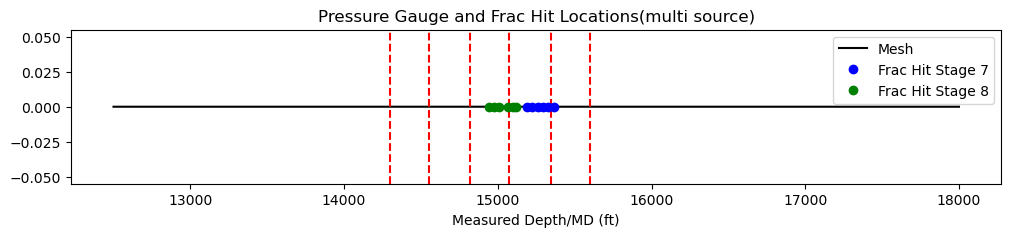

In [72]:
# Plot the location of the pressure gauge and frac hit
plt.figure(figsize=(12, 2))
plt.plot(x, np.zeros_like(x), 'k-', label='Mesh')
for gauge_md_iter in gauge_md:
    # no legend
    plt.axvline(x=gauge_md_iter, color='r', linestyle='--')
plt.plot(frac_hit_md_stg7, np.zeros_like(frac_hit_md_stg7), 'bo', label='Frac Hit Stage 7')
plt.plot(frac_hit_md_stg8, np.zeros_like(frac_hit_md_stg8), 'go', label='Frac Hit Stage 8')
plt.xlabel('Measured Depth/MD (ft)')
plt.title('Pressure Gauge and Frac Hit Locations(multi source)')
plt.legend()
plt.show()

In [74]:
# Set other parameters
d = 140
d_array = np.ones_like(x) * d

t0 = 0 # Phase 1 starts at 0

# Phase 1

In [77]:
pds_frame_phase1 = pds.PDS1D_MultiSource()

In [78]:
pds_frame_phase1.set_mesh(x)
pds_frame_phase1.set_diffusivity(d_array)
pds_frame_phase1.set_bcs('Neumann', 'Neumann')
pds_frame_phase1.set_t0(t0) # Phase 1 starts at 0

In [79]:
# Set the source idx
pds_frame_phase1.set_sourceidx(frac_hit_idx_stg7)

In [80]:
# Process the pressure gauge data to get the source term
phase_1_pg_dataframe = gauge_dataframe.copy()
phase_1_pg_dataframe.crop(stage7_start_time, stage7_end_time)

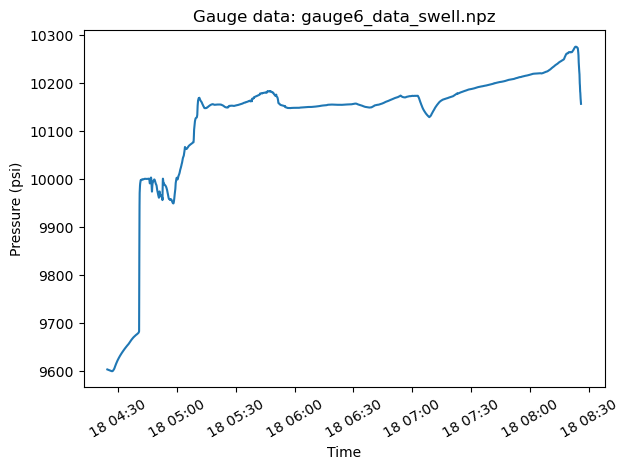

In [81]:
# QC the pressure gauge data
phase_1_pg_dataframe.plot_simple()

In [82]:
# Create the source term array
source_phase1_list = []
for source_iter in range(len(frac_hit_idx_stg7)):
    source_phase1_list.append(phase_1_pg_dataframe)

In [83]:
pds_frame_phase1.set_source(source_phase1_list)

In [92]:
u_initial = np.zeros(nx)
u_initial += phase_1_pg_dataframe.data[0]
pds_frame_phase1.set_initial(u_initial)

In [93]:
pds_frame_phase1.solve(optimizer= True, dt_init = 2, print_progress=True,
                  max_dt=30, min_dt=1e-4, tol=1e-3, safety_factor=0.9, p=2)

Each source term must be a mariner DataFrame. But got <class 'pds.DSS_analyzer_Mariner.Data1D_GAUGE.Data1D_GAUGE'>.
Self check failed. Please check the parameters.
